## Medida de correlaciones del estado de Werner

In [24]:
import matplotlib.pyplot as plt
import qutip as qt
import numpy as np
import time

In [25]:
import cmath

In [26]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120

In [27]:
start_time = time.time()

In [28]:
ro = [] # Lista donde se guardaran las matrices de densidad

In [29]:
Id = qt.qeye(4) # Operdaor identidad
Id

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

$ bell = |\phi> = \frac{1}{\sqrt{2}} \Big( |0>|0> + |1>|1> \Big) $

In [30]:
bell = qt.bell_state(state='00') # Estado de bell 00
bell_operador = bell*(bell.dag()) # Operador de bell |\phi > < \phi|

In [31]:
BellOps = qt.Qobj(bell_operador.data.toarray(),dims=[[4],[4]]) # Convertir a las dimensiones adecuadas en qutip al operador de Bell
BellOps

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.5 0.  0.  0.5]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.5 0.  0.  0.5]]

In [32]:
Plist = np.linspace(0,1,350) # Lista de elementos P de 0 a 1 con 350 elementos

**Estado de Werner**

$ \rho =  (1-p) |\phi > < \phi | + pI/4 $

In [33]:
def WernerState(p): # Calcular el estado de Werner dado un valor p
    werner = ( (1-p))*BellOps + (p/4)*Id
    return werner

In [34]:
for p in Plist: #Calcular el estado de Werner y guarda la matriz de densidad en ro
    ro.append(WernerState(p))

In [35]:
sx = qt.sigmax() 
sy = qt.sigmay()
sz = qt.sigmaz()

$S_{i} = \sigma_{iA} \otimes I_{B} $

In [36]:
SX = qt.tensor(sx,qt.qeye(2))
SY = qt.tensor(sy,qt.qeye(2))
SZ = qt.tensor(sz,qt.qeye(2))

## Skew Information ##

\begin{equation}
U_{A}(\rho_{AB}) = 1 -  \lambda_{max}(W_{AB})
\label{equation:skew_minimizacion_2}
\end{equation}

\begin{equation}
\begin{aligned}
    (W_{AB})_{ij}  =  Tr \Big[ \sqrt{\rho_{AB}} (\sigma_{iA} \otimes I_{B} )\sqrt{\rho_{AB}}  (\sigma_{jA} \otimes I_{B} ) \Big]
\end{aligned}
\label{equation:matri_W_skew_minimizacion_2}
\end{equation}

In [37]:
def CalcularSkew(Plist,ro):
        Skew = [] # Lista donde se guardaran la informacion de skew de cada matriz de densidad  
        for ii in range(0,len(Plist)):
                evals11, ekets11 =ro[ii].eigenstates()  # Obtener los eigenestados de la matriz de densidad ro[p]
                SX_base_rho = (SX.transform(ekets11))   # Hacer el cambio de base de Sx a la base de la matriz de densidad
                SY_base_rho = (SY.transform(ekets11))   # Hacer el cambio de base de Sy a la base de la matriz de densidad
                SZ_base_rho = (SZ.transform(ekets11))   # Hacer el cambio de base de Sz a la base de la matriz de densidad
                roDiagonal = (ro[ii].transform(ekets11))# Diagonalizar la matriz de densidad
                roDiagonalRaiz = qt.Qobj(np.sqrt(roDiagonal))# Obtener la razi de la matriz de densidad diagonalizada 
                g = [] # Lista donde se guardaran los elementos de la matriz W
                SigmasBaseRho = [SX_base_rho, SY_base_rho, SZ_base_rho] # Lista de los operadores Sx,Sy,Sz
                for i in range(0,3):
                    for j in range(0,3):  
                        A = roDiagonalRaiz*(qt.Qobj(SigmasBaseRho[i].data.toarray(),dims=[[4],[4]])) # \sqrt{\rho_{AB}} (\sigma_{iA} \otimes I_{B} )
                        B = roDiagonalRaiz*(qt.Qobj(SigmasBaseRho[j].data.toarray(),dims=[[4],[4]]))  # \sqrt{\rho_{AB}}  (\sigma_{jA} \otimes I_{B} )
                        AB = A*B 
                        g.append( AB.tr() )  # Elemento de la matriz ij
                Matriz_W_A1 = qt.Qobj(np.matrix([[g[0]  , g[1]  , g[2] ] # Construir la matriz W 
                                                ,[g[3]  , g[4]  , g[5] ]
                                                ,[g[6]  , g[7]  , g[8] ]]))
                evals1, ekets1 =Matriz_W_A1.eigenstates() #Obtener los eigenestados de la matriz W
                Skew.append(1-np.amax(evals1)) # Obtener la informacion de Skew
        return Skew 

## Fisher Information ##

\begin{equation}
IP(\rho_{AB}) =  \frac{1}{4} \underset{H^{A}}{min} F(\rho_{AB}, K_{A}),
\label{equation:IP_definicion}
\end{equation}

\begin{equation}
IP(\rho_{AB})=\lambda_{min}(W),
\end{equation}

\begin{equation}
\begin{aligned}
    (W)_{mn}  = \frac{1}{2} \sum_{i,j} \frac{(\lambda_{i} - \lambda_{j})^2}{\lambda_{i}+\lambda_{j}} < \psi_{i} | \sigma_{m,A}  \otimes I_{B} | \psi_{j} > < \psi_{j} |  \sigma_{n,A}  \otimes I_{B} | \psi_{i}> 
    \end{aligned}
\end{equation}

In [38]:
def Calcular_elemento(SigmasBaseRho,evals,label1,label2):
    g=[] # Lista donde se guardara los elementos para calcular el elmento de matriz W[label1.label2]  
    for i in range(0,4):
        for j in range(0,4):
            if i==j:
                g.append(0)                         
            elif (evals[i]+evals[j]) < 0.0000000000000000001: 
                g.append(0) # Si el denominador de la formula para obtener la elemento W[label1.label2] es cercana a cero, el elemnento guardado sera cero  
            else:
                g.append( (((evals[i]-evals[j])**2)/(evals[i]+evals[j]))*(SigmasBaseRho[label1][i,j]*SigmasBaseRho[label2][j,i] )  ) # Calcula el elemento de matriz W[label1.label2]                 
    return g

In [39]:
def CalcularFisherUp(Plist,ro):
        Fisher= [] #Lista donde se guardara la informacion de Fisher para cada matriz de densidad
        for ii in range(0,len(Plist)):
                evals11, ekets11 =ro[ii].eigenstates() # Obtener los eigenestados de la matriz de densidad ro[p]
                SX_base_rho = (SX.transform(ekets11))  # Hacer el cambio de base de Sx a la base de la matriz de densidad
                SY_base_rho = (SY.transform(ekets11))  # Hacer el cambio de base de Sy a la base de la matriz de densidad
                SZ_base_rho = (SZ.transform(ekets11))  # Hacer el cambio de base de Sz a la base de la matriz de densidad
                SigmasBaseRho = [SX_base_rho, SY_base_rho, SZ_base_rho] # Lista de los operadores Sx,Sy,Sz
                g11=[] #Lista donde se guardara los valores para obtener el elemento de matriz W11
                g12=[] # "                                                                "  W12
                g13=[]
                g21=[]
                g22=[]
                g23=[]
                g31=[]
                g32=[]
                g33=[]
                g11 = Calcular_elemento(SigmasBaseRho,evals11,0,0) # Calcula los valores para obtener el elemento W11
                g12 = Calcular_elemento(SigmasBaseRho,evals11,0,1) # Calcula los valores para obtener el elemento W12
                g13 = Calcular_elemento(SigmasBaseRho,evals11,0,2) # Calcula los valores para obtener el elemento W13
                g21 = Calcular_elemento(SigmasBaseRho,evals11,1,0) # "                                           " W21
                g22 = Calcular_elemento(SigmasBaseRho,evals11,1,1) # "                                           " W22
                g23 = Calcular_elemento(SigmasBaseRho,evals11,1,2) # "                                           " W23
                g31 = Calcular_elemento(SigmasBaseRho,evals11,2,0) # "                                           " W31
                g32 = Calcular_elemento(SigmasBaseRho,evals11,2,1) # "                                           " W32
                g33 = Calcular_elemento(SigmasBaseRho,evals11,2,2)# "                                            " W33
                W11 = np.sum(g11)/2.0 # Se hace la suma para obtener el elmento de matirz W11           
                W12 = np.sum(g12)/2.0 # "                                             " W12           
                W13 = np.sum(g13)/2.0 # "                                             " W13  
                W21 = np.sum(g21)/2.0 # "                                             " W21            
                W22 = np.sum(g22)/2.0 # "                                             " W22           
                W23 = np.sum(g23)/2.0 # "                                             " W23           
                W31 = np.sum(g31)/2.0 # "                                             " W31
                W32 = np.sum(g32)/2.0 # "                                             " W32
                W33 = np.sum(g33)/2.0 # "                                             " W33
                Matriz_W_A1 = qt.Qobj(np.matrix([[W11  , W12  , W13 ] # Construir la matriz W 
                                                ,[W21  , W22  , W23 ]
                                                ,[W31  , W32  , W33 ]]))
                evals1, ekets1 =Matriz_W_A1.eigenstates() #Obtener los eigenestados de la matriz W
                Fisher.append(np.amin(evals1))  # Obtener la informacion de Fisher
        return Fisher

In [40]:
Fisher1 = [] # Lista donde se guardara la informacion de Fisher para cada ro
Skew1 = [] # Lista donde se guardara la informacion de Skew para cada ro

In [41]:
Fisher1 = CalcularFisherUp(Plist,ro)
Fi1 = np.array(Fisher1)

In [42]:
Skew1 = CalcularSkew(Plist,ro)
Sk1 = np.array(Skew1)

In [43]:
Concu = []; # Lista donde se guarda la concurrencia para cada ro

In [44]:
for ii in range(0,len(Plist)):
    Concu.append(qt.concurrence(qt.Qobj(ro[ii].data.toarray(),dims=[[2, 2], [2, 2]]))) # Calcular la concurrencia para cada ro

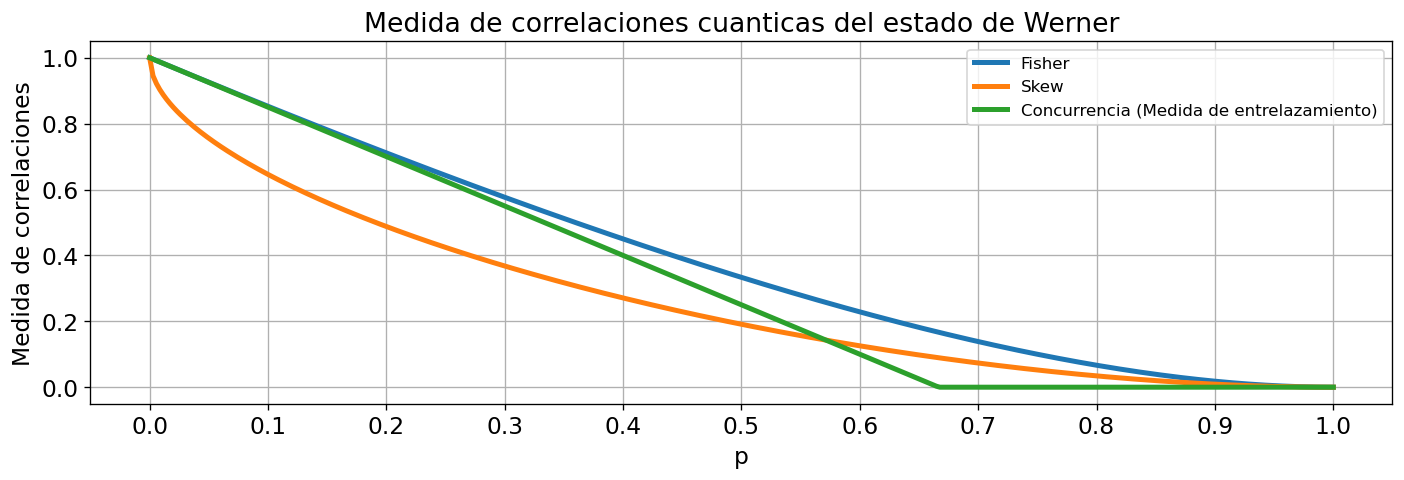

In [45]:
plt.figure(figsize = (14,4))
plt.title('Medida de correlaciones cuanticas del estado de Werner', fontsize = 16 )
plt.plot(Plist,Fi1.real, label= 'Fisher', linewidth=3)
plt.plot(Plist,Sk1.real, label= 'Skew'  ,linewidth=3)
plt.plot(Plist,Concu, label= 'Concurrencia (Medida de entrelazamiento)'  ,linewidth=3)

plt.grid()
plt.xlabel('p',fontsize = 14)
plt.ylabel('Medida de correlaciones',fontsize = 14)
plt.legend()
plt.yticks(fontsize = 14)
plt.xticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1], fontsize = 14)


plt.savefig('Medida_correlaciones_werner.png', dpi=500)
plt.show()

In [46]:
time.time() - start_time

13.477475643157959